# Importing Libraries

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import RFE

___

# Importing and Previewing Data

In [291]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [292]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [293]:
cols = ['object_id', 'creation_source', 'creation_time', 
        'last_session_creation_time', 'opted_in_to_mailing_list',
        'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
users = pd.read_csv('takehome_users.csv', usecols=cols)
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [294]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   last_session_creation_time  8823 non-null   float64
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 750.1+ KB


___

# Data Cleaning and Feature Engineering

## Dealing with NaN Values

In [295]:
#Removing entries where last_session_creation_time is NaN
users = users[users.last_session_creation_time.notna()]

#Converting NaN values in invited_by_user_id to 0
users.invited_by_user_id.fillna(0, inplace = True)

In [296]:
#Checking to make sure all NaN values accounted for
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   8823 non-null   int64  
 1   creation_time               8823 non-null   object 
 2   creation_source             8823 non-null   object 
 3   last_session_creation_time  8823 non-null   float64
 4   opted_in_to_mailing_list    8823 non-null   int64  
 5   enabled_for_marketing_drip  8823 non-null   int64  
 6   org_id                      8823 non-null   int64  
 7   invited_by_user_id          8823 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 620.4+ KB


## Converting Dates to Datetime Objects

In [297]:
#Converting engagement.time_stamp to datetime format
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

#Setting engagement time_stamp as the index
engagement = engagement.set_index('time_stamp', drop= True)

#Converting users.creation_time to datetime format
users.creation_time = pd.to_datetime(users.creation_time)

#Converting users.last_session_creation_time to datetime format
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit = 's')

In [298]:
#Checking datetime formats
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   creation_source             8823 non-null   object        
 3   last_session_creation_time  8823 non-null   datetime64[ns]
 4   opted_in_to_mailing_list    8823 non-null   int64         
 5   enabled_for_marketing_drip  8823 non-null   int64         
 6   org_id                      8823 non-null   int64         
 7   invited_by_user_id          8823 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 620.4+ KB


## Finding the Adopted Users

In [299]:
#Function found on internet
def adopted_user(x):    
    
    '''takes a users input and returns whether or not 
       they have been active within any 7-day period'''
    
    #Select inputed user_id
    df_temp = engagement.loc[engagement['user_id'] == x]
    
    #Resample to determine user activity for every day
    df_temp = df_temp.resample('D').mean().dropna()
    
    #Instantiating 'adopted' variable
    adopted = 0
    
    #Loop through active days until the second to last day
    for i in range(len(df_temp)-2): 
        
        #Calculates difference between every 1st and 3rd day 
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7):
            
            #Changes adopted value to 1
            adopted = 1
            break
            
        else:
            #Maintains adopted value of 0
            adopted = 0
            
    #Returns adopted value        
    return adopted

In [300]:
#Using the 
users['adopted_user'] = users['object_id'].apply(adopted_user)
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


## Creating 'active_time' Feature

In [301]:
#Subtracting creation time from last session time to get active time in days
users['active_days'] = pd.to_numeric((users['last_session_creation_time'] - users['creation_time']).dt.days)

In [302]:
#Checking features
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,active_days
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,136
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,5


## Removing Datetime Features

In [303]:
users.drop(['creation_time', 'last_session_creation_time'], axis = 1, inplace = True)
users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,active_days
0,1,GUEST_INVITE,1,0,11,10803.0,0,0
1,2,ORG_INVITE,0,0,1,316.0,1,136
2,3,ORG_INVITE,0,0,94,1525.0,0,0
3,4,GUEST_INVITE,0,0,1,5151.0,0,1
4,5,GUEST_INVITE,0,0,193,5240.0,0,5


## Encoding Categorical Features

In [304]:
final_df = pd.get_dummies(users, columns = ['creation_source'])
final_df.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,active_days,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1,0,11,10803.0,0,0,1,0,0,0,0
1,2,0,0,1,316.0,1,136,0,1,0,0,0
2,3,0,0,94,1525.0,0,0,0,1,0,0,0
3,4,0,0,1,5151.0,0,1,1,0,0,0,0
4,5,0,0,193,5240.0,0,5,1,0,0,0,0


___

# Visualizations

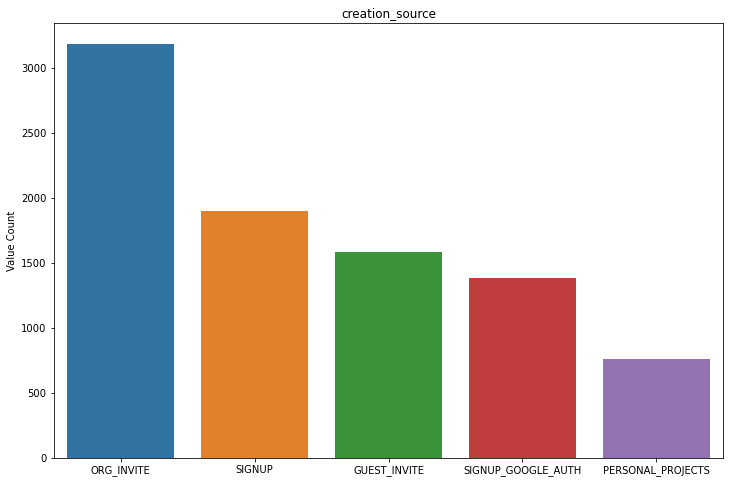

ORG_INVITE            3188
SIGNUP                1898
GUEST_INVITE          1588
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: creation_source, dtype: int64


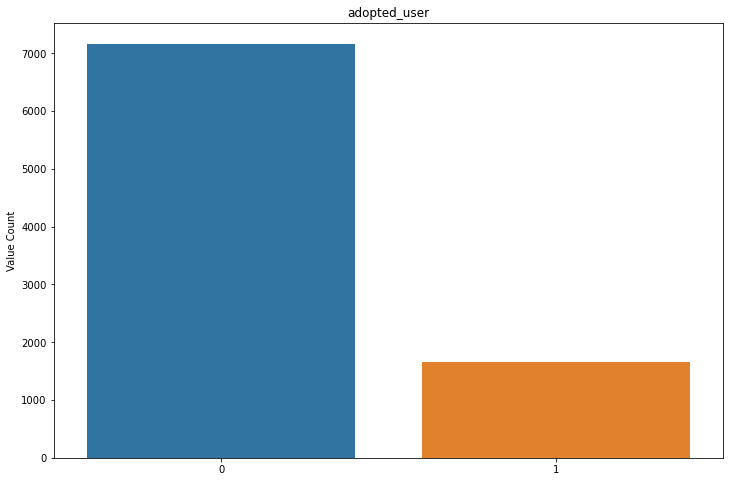

0    7167
1    1656
Name: adopted_user, dtype: int64


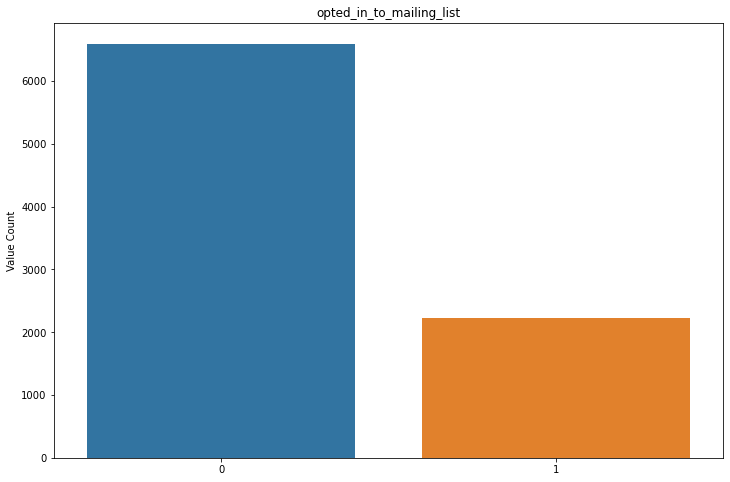

0    6597
1    2226
Name: opted_in_to_mailing_list, dtype: int64


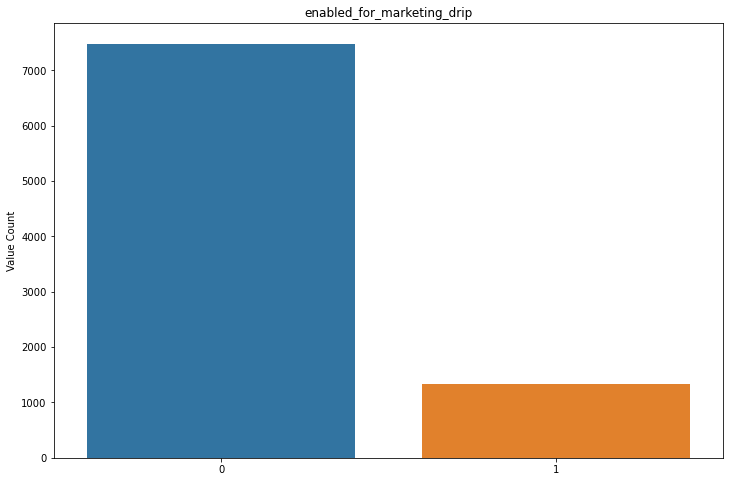

0    7482
1    1341
Name: enabled_for_marketing_drip, dtype: int64


In [307]:
cat_features = ['creation_source', 'adopted_user', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']

for feature in cat_features:
    plt.figure(figsize = (12,8))
    sns.barplot(x = list(users[feature].value_counts().index), y = users[feature].value_counts())
    plt.title(feature)
    plt.ylabel('Value Count')
    plt.show()
    print(users[feature].value_counts())

From these visualizations I was able to notice a few interesting things:

- There are only **1656 adopted users**, out of a total of **12,000 users**. This means that **0.138%** of total users are adopted users.
- **4,254 users** joined through an invitation to an organizaiton.

___

# Modeling

In [313]:
#Train test split
X = final_df.drop(['adopted_user'], axis = 1).copy()
y = final_df['adopted_user'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1419
           1       0.93      0.87      0.90       346

    accuracy                           0.96      1765
   macro avg       0.95      0.93      0.94      1765
weighted avg       0.96      0.96      0.96      1765

Confusion Matrix:


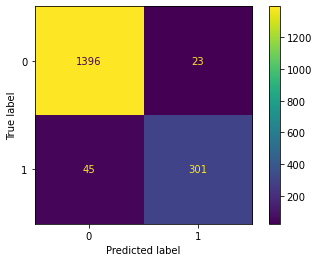

In [314]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample')

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

#Classification Report
print('Classification Report:\n',
    classification_report(y_test, y_pred))

#Printing the confusion matrix for model testing
print('Confusion Matrix:\n ',
    plot_confusion_matrix(rfc, X_test, y_test))

## Calculating Feature Importance

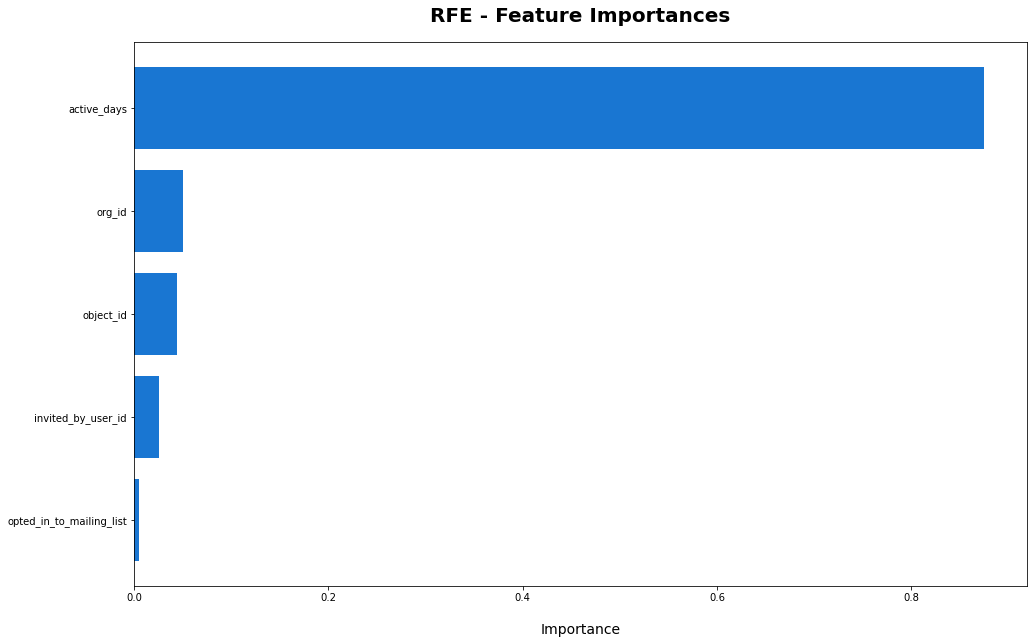

In [322]:
#Instantiating the RFE model
rfe = RFE(estimator = rfc, n_features_to_select = 5)

#Fitting the RFE model to the training data
rfe.fit(X_train, y_train)

#Creating list of feature columns
new_columns = X.loc[:, rfe.support_].columns

#Creating dataframe of features and their importances
dset = pd.DataFrame()
dset['attr'] = new_columns
dset['importance'] = rfe.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending = True)

#Plotting the data
plt.figure(figsize = (16,10))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFE - Feature Importances', fontsize = 20, fontweight='bold', pad =20)
plt.xlabel('Importance', fontsize = 14, labelpad = 20)
plt.show()

___

# Conclusion and Final Thoughts

From the Feature Importances visualization it is apparent that the length of time that a user has been using the service is very important. This suggests that to increase adopted users of the service, Relax should encourage users to login and use the service if they have not been active recently. 